# ML in Cybersecurity: Task II

## Team
  * **Team name**:  *R2D2C3P0BB8*
  * **Members**:  <br/> **Navdeeppal Singh (s8nlsing@stud.uni-saarland.de)** <br/> **Shahrukh Khan (shkh00001@stud.uni-saarland.de)** <br/> **Mahnoor Shahid (mash00001@stud.uni-saarland.de)**


## Logistics
  * **Due date**: 25th Nov. 2021, 23:59:59 (email the completed notebook including outputs to mlcysec_ws2022_staff@lists.cispa.saarland)
  * Email the completed notebook to mlcysec_ws2022_staff@lists.cispa.saarland 
  * Complete this in the previously established **teams of 3**
  * Feel free to use the course forum to discuss.
  
  
## About this Project
In this project, we dive into the vulnerabilities of machine learning models and the difficulties of defending against them. To this end, we ask you to implement an evasion attack (craft adversarial examples) yourselves, and defend your own model.   


## A Note on Grading
The total number of points in this project is 100. We further provide the number of points achievable with each excercise. You should take particular care to document and visualize your results.

Whenever possible, please use tools like tables or figures to compare the different findings


 
## Filling-in the Notebook
You'll be submitting this very notebook that is filled-in with (all) your code and analysis. Make sure you submit one that has been previously executed in-order. (So that results/graphs are already visible upon opening it). 

The notebook you submit **should compile** (or should be self-contained and sufficiently commented). Check tutorial 1 on how to set up the Python3 environment.

It is extremely important that you **do not** re-order the existing sections. Apart from that, the code blocks that you need to fill-in are given by:
```
#
#
# ------- Your Code -------
#
#
```
Feel free to break this into multiple-cells. It's even better if you interleave explanations and code-blocks so that the entire notebook forms a readable "story".


## Code of Honor
We encourage discussing ideas and concepts with other students to help you learn and better understand the course content. However, the work you submit and present **must be original** and demonstrate your effort in solving the presented problems. **We will not tolerate** blatantly using existing solutions (such as from the internet), improper collaboration (e.g., sharing code or experimental data between groups) and plagiarism. If the honor code is not met, no points will be awarded.

 
  ---

In [1]:
import time 
 
import numpy as np 
import matplotlib.pyplot as plt 

import json 
import time 
import pickle 
import sys 
import csv 
import os 
import os.path as osp 
import shutil 
from collections import namedtuple
import pandas as pd

from IPython.display import display, HTML
 
%matplotlib inline 
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots 
plt.rcParams['image.interpolation'] = 'nearest' 
plt.rcParams['image.cmap'] = 'gray' 
 
# for auto-reloading external modules 
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython 
%load_ext autoreload
%autoreload 2

In [2]:
# Some suggestions of our libraries that might be helpful for this project
from collections import Counter          # an even easier way to count
from multiprocessing import Pool         # for multiprocessing
from tqdm import tqdm                    # fancy progress bars

# Load other libraries here.
# Keep it minimal! We should be easily able to reproduce your code.
# We only support sklearn and pytorch.
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.utils.data as data

# We preload pytorch as an example
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset, random_split, SubsetRandomSampler
# Please set random seed to have reproduceable results, e.g. torch.manual_seed(123)
random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)

In [3]:
compute_mode = 'cpu'

if compute_mode == 'cpu':
    device = torch.device('cpu')
elif compute_mode == 'gpu':
    # If you are using pytorch on the GPU cluster, you have to manually specify which GPU device to use
    # It is extremely important that you *do not* spawn multi-GPU jobs.
    os.environ["CUDA_VISIBLE_DEVICES"] = '0'    # Set device ID here
    device = torch.device('cuda')
else:
    raise ValueError('Unrecognized compute mode')

#### Helpers

In case you choose to have some methods you plan to reuse during the notebook, define them here. This will avoid clutter and keep rest of the notebook succinct.

In [4]:
# data loading helper
def _get_data(DATA_PATH, TRAIN_BATCH_SIZE, TEST_BATCH_SIZE):
    try:
        """
        This method is created to split the MNIST data into training, validation and testing set accordingly 
        and load it into dataloaders. Also, to specify any transformations required to perform on the data. 
        As well as this method is being called multiple times in hyper parameter tuning where different batch 
        sizes are being tested
        ...

        Parameters
        ----------
        DATA_PATH : str
            specifies the path directory where dataset will be downloaded
        TRAIN_BATCH_SIZE : int
            specifies the batch size in the training loader
        TEST_BATCH_SIZE : int
            specifies the batch size in the training loader
            
        Returns
        -------
        train_loader, validation_loader, test_loader with the specified batch sizes 
            
        """
        tranformations = transforms.Compose([transforms.ToTensor()])
        
        mnist_training_dataset = datasets.MNIST(root=DATA_PATH+'train', train=True, download=True, transform=tranformations)
        mnist_testing_dataset = datasets.MNIST(root=DATA_PATH+'test', train=False, download=True, transform=tranformations)
        
        training_dataset, validation_dataset = random_split(mnist_training_dataset, [int(0.8*len(mnist_training_dataset)), int(0.2*len(mnist_training_dataset))])
        
        train_loader = DataLoader(training_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
        validation_loader = DataLoader(training_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=False)
        test_loader = DataLoader(mnist_testing_dataset, batch_size=TEST_BATCH_SIZE, shuffle=False)
        
        return train_loader, validation_loader, test_loader
    
    except Exception as e:
        print('Unable to get data due to ', e)

## data sample helper
def _get_test_data_sample(DATA_PATH, TEST_BATCH_SIZE=1, SAMPLE_SIZE=1000):
    try:
        """
        This method creates a subset from testset for creating adversarial examples
        ...

        Parameters
        ----------
        DATA_PATH : str
            specifies the path directory where dataset will be downloaded
        TRAIN_BATCH_SIZE : int
            specifies the batch size in the test subset loader
        SAMPLE_SIZE : int
            specifies the sample size of the subset
            
        Returns
        -------
        test_subset_loader
            
        """
        tranformations = transforms.Compose([transforms.ToTensor()])
        
        mnist_testing_dataset = datasets.MNIST(root=DATA_PATH+'test', 
                                              train=False, download=True, 
                                              transform=tranformations)
        dataset_size = len(mnist_testing_dataset)
        dataset_indices = list(range(dataset_size))
        np.random.shuffle(dataset_indices)
        test_subset_idx  = dataset_indices[:SAMPLE_SIZE]
        test_subset_sampler = SubsetRandomSampler(test_subset_idx)
        test_subset_loader = DataLoader(mnist_testing_dataset, 
                                        batch_size=TEST_BATCH_SIZE, 
                                        shuffle=False, sampler=test_subset_sampler)
        
        return test_subset_loader
    
    except Exception as e:
        print('Unable to get data due to ', e)



# 1. Attacking an ML-model (30 points) 

In this section, we implement an attack ourselves. First, however, you need a model you can attack. Feel free to choose the DNN/ConvNN from task 1.



## 1.1: Setting up the model and data (4 Points)

Load the MNIST data, as done in task 1. 

Re-use the model from task 1 here and train it until it achieves reasonable accuracy (>92%).

If you have the saved checkpoint from task 1, you can load it directly. But please compute here the test accuracy using this checkpoint.  

**Hint:** In order to save computation time for the rest of exercise, you might consider having a relatively small model here.

**Hint**: You might want to save the trained model to save time later.

In [5]:
## 1. Loading data

DATA_PATH = '../data/'
TRAIN_BATCH_SIZE, TEST_BATCH_SIZE = 64, 64
_, _, test_loader = _get_data(DATA_PATH, TRAIN_BATCH_SIZE, TEST_BATCH_SIZE)

In [6]:
## 2. Defining model

class CNN_Network(nn.Module):
    def __init__(self, model_params):
        """
        This class is created to specify the Convolutional Neural Network on which MNIST dataset is trained on, 
        validated and later tested. 
        It consist of one input layer, one output layer can consist of multiple hidden layers all of which is 
        specified by the user as provided through model_paramaters
        Size of the kernel, stride and padding can also be adjusted by the user as provided through model_paramaters
        ...

        Parameters
        ----------
        model_params : dictionary
            provides the model with the required input size, hidden layers and output size
            
            model_params = {
            'INPUT_SIZE' : int,
            'HIDDEN_LAYERS' : list(int),
            'OUTPUT_SIZE' : int,
            'KERNEL' : int,
            'STRIDE' : int,
            'PADDING' : int
        }
        """
        try:
            super(CNN_Network, self).__init__()
            
            layers = []
            
            for input_channel, out_channel in zip([model_params['INPUT_SIZE']] + model_params['HIDDEN_LAYERS'][:-1], 
                                                     model_params['HIDDEN_LAYERS'][:len(model_params['HIDDEN_LAYERS'])]):
                layers.append(nn.Conv2d(input_channel, out_channel, model_params['KERNEL'], model_params['STRIDE'], model_params['PADDING'], bias=True))
                layers.append(nn.MaxPool2d(2, 2))
                layers.append(nn.ReLU())
            layers.append(nn.Flatten(1))      
            layers.append(nn.Linear(model_params['HIDDEN_LAYERS'][-1], model_params['OUTPUT_SIZE'], bias=True))

            self.layers = nn.Sequential(*layers)
        
        except Exception as e:
            print('initializing failed due to ', e)
    
    def forward(self, x):
        try:
            return self.layers(x)
        
        except Exception as e:
            print('forward pass failed due to ', e)
      

In [7]:
## 3. initializing the pre-trained model from assignment 1
model_params = {
        'INPUT_SIZE' : 1,
        'HIDDEN_LAYERS' : [160, 100, 64, 10],
        'OUTPUT_SIZE' : 10,
        'KERNEL' : 3,
        'STRIDE' : 1,
        'PADDING' : 1
}
  
undefended_model = CNN_Network(model_params).to(compute_mode)
criterion = nn.CrossEntropyLoss().to(compute_mode)

In [8]:
# loading checkpoint and evaluating on test set
def _test_model(model, test_loader, BEST_MODEL):
    try:
        model.load_state_dict(torch.load(BEST_MODEL, map_location=compute_mode))
        model.eval()
        with torch.no_grad():
            correct_predictions = []
            testing_acc_scores = []
            wrong_predictions = []
            all_targets = []
            all_preds = []


            for images, targets in iter(test_loader):
                images = images.to(compute_mode)
                targets = targets.to(compute_mode)
                outputs = model(images)
                
                _, preds = torch.max(outputs, 1)
                correct_indicies = (preds == targets).nonzero(as_tuple=True)[0]
                c_images = images[correct_indicies]
                c_targets = targets[correct_indicies]
                c_correct_preds = preds[correct_indicies]
                testing_acc_scores.append(len(correct_indicies)/targets.shape[0])

                wrong_indicies = (preds != targets).nonzero(as_tuple=True)[0]
                w_images = images[wrong_indicies]
                w_targets = targets[wrong_indicies]
                w_wrong_preds = preds[wrong_indicies]
            
                correct_predictions += zip(c_images, c_targets, c_correct_preds)
                wrong_predictions += zip(w_images, w_targets, w_wrong_preds)
                all_targets+= zip(targets.cpu().numpy())
                all_preds+= zip(preds.cpu().numpy())

            return (sum(testing_acc_scores)/len(testing_acc_scores))*100, correct_predictions, wrong_predictions, all_targets, all_preds
        
    except Exception as e:
            print('Error occured in testing the model = ', e)

In [9]:
(test_accuracy, 
 correct_predictions, 
 wrong_predictions, 
 all_targets, all_preds) = _test_model(undefended_model, test_loader, 
                                       BEST_MODEL='../Accuracy_99.8875_batchsize_64_lr_0.001.ckpt' )

/usr/local/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


## 1.2: Implementing the FGSM attack (7 Points)

We now want to attack the model trained in the previous step. We will start with the FGSM attack as a simple example. 

Please implement the FGSM attack mentioned in the lecture. 

More details: https://arxiv.org/pdf/1412.6572.pdf


In [10]:
#implementation of FGSM Attack
def fgsm_attack(example, epsilon, x_grad):
    """
    Implementation of FGSM attack for a single example.
    example: Input image 
    epsilon: Pertubation budget 
    x_grad: Gradient of loss function wrt input image
    """
    # computing the sign (elementwise) of input (x) gradient
    x_grad_sign = x_grad.sign()
    # generating adversarial example using FGSM formula of x + delta, where delta = epsilon * input_gradient_sign
    perturbed_example = example + epsilon*x_grad_sign
    # perform house keeping to make sure image pixels don't go out of limits of [0,1] range
    clipped_perturbed_example = torch.clamp(perturbed_example, 0, 1)
    # return the adversarial example 
    return clipped_perturbed_example

## 1.3: Adversarial sample set (7 Points)

* Please generate a dataset containing at least 1,000 adversarial examples using FGSM.

* Please vary the perturbation budget (3 variants) and generate 1,000 adversarial examples for each. 
    * **Hint**: you can choose epsilons within, e.g., = [.05, .1, .15, .2, .25, .3],  using MNIST pixel values in the interval       [0, 1]

* Compute the accuracy of each attack set. 

In [11]:
## dictionary for storing 3 sets of adversarial examples
fgsm_sets = {}
## epsilon values
epsilons = [0.1, 0.2, 0.3]
epsilon_param = namedtuple('epsilon_param', ['epsilon'])

# creating the 1000 example dataset first
test_subset_dataloader = _get_test_data_sample(DATA_PATH)

In [14]:
for epsilon in tqdm(epsilons):
    epsilon_val = epsilon_param(epsilon=epsilon)
    fgsm_sets[epsilon_val] = {
         "images": [],
         "targets": []
     }
    for x_data, target in test_subset_dataloader:
        undefended_model.train()
        # move inputs and labels to the compute device
        x_data= x_data.to(device) 
        target = target.to(device)
        # switch on the gradient computations wrt to input, as need those computations for FGSM formula
        x_data.requires_grad = True
        # peform the forward pass of the model
        output = undefended_model(x_data)
        #print(output)
        # compute the loss
        loss = criterion(output, target)
        # re-initialized the gradient variables
        undefended_model.zero_grad()
        # perform the backward pass on loss function wrt to inputs and weights
        loss.backward()
        # Collect datagrad
        x_grad = x_data.grad.data

        # perform the FGSM computation for generating adversarial example for a given epsilon
        fgsm_output = fgsm_attack(x_data, epsilon, x_grad)
        print (output.max(1, keepdim=True)[1], target )
        #print(torch.max(output, 1)[1])
        
    break

  0%|          | 0/3 [00:00<?, ?it/s]

tensor([[4]]) tensor([4])
tensor([[8]]) tensor([8])
tensor([[2]]) tensor([2])
tensor([[0]]) tensor([0])
tensor([[9]]) tensor([9])
tensor([[2]]) tensor([2])
tensor([[5]]) tensor([5])
tensor([[5]]) tensor([5])
tensor([[7]]) tensor([7])
tensor([[5]]) tensor([5])
tensor([[3]]) tensor([3])
tensor([[1]]) tensor([1])
tensor([[7]]) tensor([7])
tensor([[3]]) tensor([3])
tensor([[1]]) tensor([1])
tensor([[3]]) tensor([3])
tensor([[1]]) tensor([1])
tensor([[0]]) tensor([0])
tensor([[3]]) tensor([3])
tensor([[8]]) tensor([8])
tensor([[0]]) tensor([0])
tensor([[9]]) tensor([9])
tensor([[4]]) tensor([4])
tensor([[7]]) tensor([7])
tensor([[0]]) tensor([0])
tensor([[3]]) tensor([3])
tensor([[2]]) tensor([2])
tensor([[3]]) tensor([3])
tensor([[9]]) tensor([9])
tensor([[1]]) tensor([1])
tensor([[5]]) tensor([5])
tensor([[2]]) tensor([2])
tensor([[9]]) tensor([9])
tensor([[4]]) tensor([4])
tensor([[2]]) tensor([2])
tensor([[5]]) tensor([5])
tensor([[6]]) tensor([6])
tensor([[6]]) tensor([6])
tensor([[2]]

tensor([[1]]) tensor([1])
tensor([[2]]) tensor([2])
tensor([[6]]) tensor([6])
tensor([[2]]) tensor([2])
tensor([[1]]) tensor([1])
tensor([[4]]) tensor([4])
tensor([[0]]) tensor([0])
tensor([[8]]) tensor([8])
tensor([[9]]) tensor([9])
tensor([[4]]) tensor([4])
tensor([[3]]) tensor([3])
tensor([[0]]) tensor([0])
tensor([[8]]) tensor([8])
tensor([[1]]) tensor([1])
tensor([[2]]) tensor([2])
tensor([[7]]) tensor([7])
tensor([[3]]) tensor([3])
tensor([[4]]) tensor([4])
tensor([[3]]) tensor([3])
tensor([[6]]) tensor([6])
tensor([[6]]) tensor([6])
tensor([[3]]) tensor([3])
tensor([[9]]) tensor([9])
tensor([[4]]) tensor([4])
tensor([[0]]) tensor([0])
tensor([[0]]) tensor([0])
tensor([[8]]) tensor([8])
tensor([[1]]) tensor([1])
tensor([[1]]) tensor([1])
tensor([[7]]) tensor([7])
tensor([[9]]) tensor([9])
tensor([[2]]) tensor([2])
tensor([[4]]) tensor([4])
tensor([[1]]) tensor([1])
tensor([[8]]) tensor([8])
tensor([[8]]) tensor([8])
tensor([[1]]) tensor([1])
tensor([[9]]) tensor([9])
tensor([[5]]

tensor([[8]]) tensor([8])
tensor([[6]]) tensor([6])
tensor([[2]]) tensor([2])
tensor([[5]]) tensor([5])
tensor([[9]]) tensor([9])
tensor([[9]]) tensor([9])
tensor([[4]]) tensor([4])
tensor([[0]]) tensor([0])
tensor([[5]]) tensor([5])
tensor([[4]]) tensor([4])
tensor([[7]]) tensor([7])
tensor([[2]]) tensor([2])
tensor([[4]]) tensor([4])
tensor([[3]]) tensor([3])
tensor([[2]]) tensor([2])
tensor([[5]]) tensor([5])
tensor([[2]]) tensor([2])
tensor([[2]]) tensor([2])
tensor([[7]]) tensor([7])
tensor([[4]]) tensor([4])
tensor([[2]]) tensor([2])
tensor([[9]]) tensor([9])
tensor([[1]]) tensor([1])
tensor([[5]]) tensor([5])
tensor([[1]]) tensor([1])
tensor([[2]]) tensor([2])
tensor([[2]]) tensor([2])
tensor([[3]]) tensor([3])
tensor([[2]]) tensor([2])
tensor([[0]]) tensor([0])
tensor([[0]]) tensor([0])
tensor([[2]]) tensor([2])
tensor([[2]]) tensor([2])
tensor([[0]]) tensor([0])
tensor([[6]]) tensor([6])
tensor([[8]]) tensor([8])
tensor([[2]]) tensor([2])
tensor([[0]]) tensor([0])
tensor([[7]]

tensor([[4]]) tensor([4])
tensor([[3]]) tensor([3])
tensor([[3]]) tensor([3])
tensor([[5]]) tensor([5])
tensor([[7]]) tensor([7])
tensor([[5]]) tensor([5])
tensor([[0]]) tensor([0])
tensor([[1]]) tensor([1])
tensor([[9]]) tensor([9])
tensor([[6]]) tensor([4])
tensor([[0]]) tensor([0])
tensor([[2]]) tensor([2])
tensor([[5]]) tensor([5])
tensor([[5]]) tensor([5])
tensor([[1]]) tensor([8])
tensor([[0]]) tensor([0])
tensor([[9]]) tensor([9])
tensor([[1]]) tensor([1])
tensor([[5]]) tensor([5])
tensor([[7]]) tensor([7])
tensor([[7]]) tensor([7])


  0%|          | 0/3 [00:08<?, ?it/s]

tensor([[6]]) tensor([6])
tensor([[8]]) tensor([8])
tensor([[2]]) tensor([2])
tensor([[5]]) tensor([5])
tensor([[4]]) tensor([4])
tensor([[2]]) tensor([2])
tensor([[9]]) tensor([9])
tensor([[0]]) tensor([0])
tensor([[5]]) tensor([5])
tensor([[3]]) tensor([3])
tensor([[2]]) tensor([2])
tensor([[3]]) tensor([3])
tensor([[1]]) tensor([1])
tensor([[7]]) tensor([7])
tensor([[0]]) tensor([0])


## 1.4: Visualizing the results (7 Points)

* Please chose one sample for each class (for example the first when iterating the test data) and plot the (ten) adversarial examples as well as the predicted label (before and after the attack)

* Please repeat the visualization for the three sets you have created 

NameError: name 'images_ori' is not defined

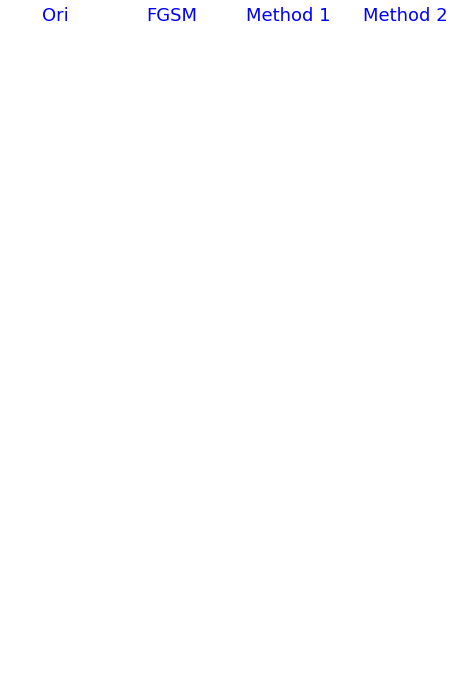

In [13]:
#
#
# ------- Your Code -------
#
#

# template code (Please feel free to change this)
# (each column corresponds to one attack method)
col_titles = ['Ori','FGSM','Method 1', 'Method 2'] 
nsamples = 10
nrows = nsamples
ncols = len(col_titles)

fig, axes = plt.subplots(nrows,ncols,figsize=(8,12))  # create the figure with subplots
[ax.set_axis_off() for ax in axes.ravel()]  # remove the axis

for ax, col in zip(axes[0], col_titles): # set up the title for each column
    ax.set_title(col,fontdict={'fontsize':18,'color':'b'})

for i in range(nsamples):
    axes[i,0].imshow(images_ori[i])
    axes[i,1].imshow(adv_FGSM[i])
    axes[i,2].imshow(adv_Method1[i])
    axes[i,3].imshow(adv_Method2[i])
                  

## 1.5: Analyzing the results (5 Points)

Please write a brief summary of your findings.  

* Does the attack always succeed (the model makes wrong prediction on the adversarial sample)? What is the relationship between the attack success rate and the perturbation budget?
* How about the computation cost of the attack? (you can report the time in second) 
* Does the attack require white-box access to the model?
* Feel free to report your results via tables or figures, and mention any other interesting observations 



**Your answers go here**

# 2. Defending an ML model (35 points) 

So far, we have focused on attacking an ML model. In this section, we want you to defend your model. 


## 2.1: Implementing the adversarial training defense (20 Points)

* We would like to ask you to implement the adversarial training defense (https://arxiv.org/pdf/1412.6572.pdf) mentioned in the lecture. 

* You can use the **FGSM adversarial training** method (i.e., train on FGSM examples). 

* You can also check the adversarial training implementation in other papers, e.g., http://proceedings.mlr.press/v97/pang19a/pang19a.pdf 

* Choose a certain **maximum perturbation budget** during training that is in the middle of the range you have experimented with before. 

* We do not require the defense to work perfectly - but what we want you to understand is why it works or why it does not work.

**Hint:** You can save the checkpoint of the defended model as we would need it to for the third part of this exercise.


In [ ]:
#
#
# ------- Your Code -------
#
#


## 2.2: Evaluation (10 Points)

* Craft adversarial examples using the **defended** model. This entails at least 1,000 examples crafted via FGSM. 
    * Create one set using a budget that is **less than (within)** the one used in training.
    * Create another set using a budget that is **higher than** the one used in training. 
    * You can use two values of epsilons from question 1.3 
    
* Evaluate the **defended** model on these two adversarial examples sets. 


In [ ]:
#
#
# ------- Your Code -------
#
#

print('Accuracy on the lower-budget adversarial samples (FGSM) %.2f'%acc_FGSM1)
print('Accuracy on the lower-budget adversarial samples (FGSM) after defense %.2f'%acc_FGSM_defend1)

print('Accuracy on the higher-budget adversarial samples (FGSM) %.2f'%acc_FGSM2)
print('Accuracy on the higher-budget adversarial samples (FGSM) after defense %.2f'%acc_FGSM_defend2)

## 2.3 Discussion (5 points)

* How successful was the defense against the attack compared to the undefended model? How do you interpret the difference?
* How did the two sets differ?

**Your answers go here**

# 3: I-FGSM attack (35 points) 

* FGSM is one of the simplest and earliest attacks. Since then, many more advanced attacks have been proposed. 
* One of them is the Iterative-FGSM (https://arxiv.org/pdf/1607.02533.pdf), where the attack is repeated multiple times.
* In this part, we ask you to please implement the iterative FGSM attack. 



## 3.1: Implementing the I-FGSM attack (10 Points)

**Hints**: 

* Your code should have an attack loop. At each step, the FGSM attack that you have implemented before is computed using a small step.
* After each step, you should perform a per-pixel clipping to make sure the image is in the allowed range, and that the perturbation is within budget.


In [ ]:
#
#
# ------- Your Code -------
#
#


## 3.2: Attack the undefended model (5 Points)

* We will first attack the **undefended model** (i.e., without adversarial training).

* Choose one perturbation budget from Question **1.3** for comparison. 

    * Hint: A simple way to choose the small step is to divide the total budget by the number of steps (e.g., 10).

* Please generate 1000 adversarial examples using the **undefended** model and the **I-FGSM** you implemented. 

* Please compute the accuracy of the adversarial set on the **undefended** model. 

In [ ]:
#
#
# ------- Your Code -------
#
#


### 3.2.1: Findings and comparison with FGSM (8 points)

* Please report your findings. How successful was the attack? 

* What do you expect when increasing the number of steps? (you can experiment with different parameters of the attack and report your findings) 

* Compare with the basic FGSM. Using the same perturbation budget and using the same model, which attack is more successful? Why do you think this is the case? What about the computation time?

* Feel free to report any interesting observations. 

**Your answers go here**

## 3.3: Attack the defended model (5 poinst) 

* In the previous question, we attacked the **undefended model**. 

* Now, we want to explore how successful the previous implemented defense (FGSM adversarial training) is againts this new attack. (we will not implement a new defense here, we will be reusing your previous checkpoint of the **defended model**)


* Use the **defended model** to create one set of adversarial examples. Use a perturbation budget from Question **2.2** for comparison.  

In [ ]:
#
#
# ------- Your Code -------
#
#

In [ ]:
preds = torch.Tensor([1,2,3])
targets=torch.Tensor([3,2,1])
(preds == targets).nonzero(as_tuple=True)[0]

### 3.3.1: Discussion (7 points) 
* Please report your results. How successful was the attack on the defended model? 
* Compare it with the success of the FGSM attack on the defended model. What do you observe? How do you interpret the difference? 
* How do you think you can improve the defense against I-FGSM attack?


* Feel free to state any interesting findings you encountered during this project.

**Your answers go here**